In [234]:
# !pip install contractions
# !pip install nlpaug
import warnings
warnings.filterwarnings('ignore')

In [235]:
import pandas as pd

df = pd.read_csv('/content/financial_news_mt.csv', delimiter=',', encoding='latin-1', header=None)
df = df.drop(0, axis=1)
df = df.drop(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1967 entries, 1 to 1967
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   1       1967 non-null   object
 1   2       1967 non-null   object
 2   3       1967 non-null   object
dtypes: object(3)
memory usage: 46.2+ KB


In [236]:
df.columns = ['label', 'en_text', 'id_text']
df.head()

,label,en_text,id_text
1,negative,The international electronic industry company ...,Perusahaan industri elektronik internasional E...
2,positive,With the new production plant the company woul...,"Dengan pabrik produksi baru, perusahaan akan m..."
3,positive,According to the company 's updated strategy f...,Sesuai dengan strategi terbaru perusahaan untu...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,PEMBIAYAAN UNTUK PERTUMBUHAN ASPOCOMP Aspocomp...
5,positive,"For the last quarter of 2010 , Componenta 's n...","Untuk kuartal terakhir tahun 2010, penjualan b..."


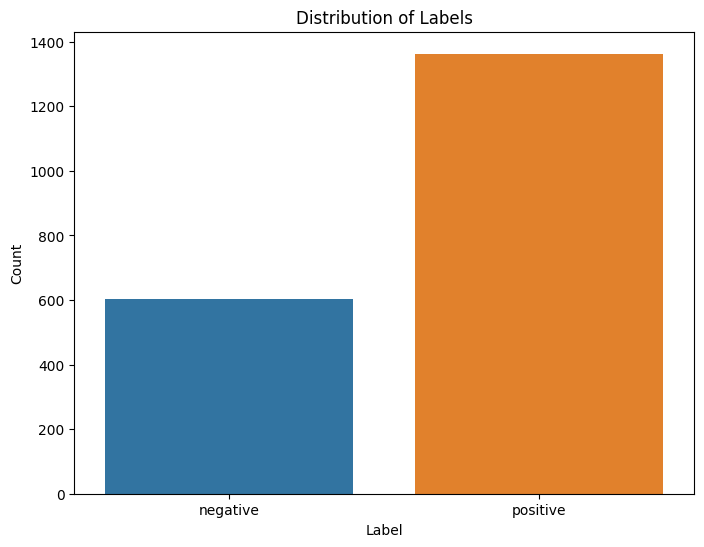

In [237]:
import seaborn as sns
import matplotlib.pyplot as plt

# Membuat plot distribusi kolom 'label'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

In [238]:
from bs4 import BeautifulSoup
import re
import unicodedata
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

indonesian_stopwords = set(stopwords.words('indonesian'))

def stopwords_removal(words, language):
    if language == 'english':
        list_stopwords = nltk.corpus.stopwords.words('english')
    elif language == 'indonesian':
        list_stopwords = indonesian_stopwords
    return [word for word in words if word not in list_stopwords]


def pre_process_text(text, language):
    text = text.lower()
    text = strip_html_tags(text)
    text = text.translate(text.maketrans("\n\t\r", "   "))
    text = remove_accented_chars(text)
    text = contractions.fix(text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text, re.I | re.A)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    text = word_tokenize(text)
    text = stopwords_removal(text, language)
    return " ".join(text)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [239]:
df['en_text'] = df['en_text'].apply(lambda x: pre_process_text(x, 'english'))
df['id_text'] = df['id_text'].apply(lambda x: pre_process_text(x, 'indonesian'))

In [240]:
df.head()

,label,en_text,id_text
1,negative,international electronic industry company elco...,perusahaan industri elektronik internasional e...
2,positive,new production plant company would increase ca...,pabrik produksi perusahaan meningkatkan kapasi...
3,positive,according company updated strategy years 20092...,sesuai strategi terbaru perusahaan 20092012 ba...
4,positive,financing aspocomp growth aspocomp aggressivel...,pembiayaan pertumbuhan aspocomp aspocomp agres...
5,positive,last quarter 2010 componenta net sales doubled...,kuartal 2010 penjualan bersih componenta berli...


In [241]:
from sklearn.utils import resample

data_majority = df[df['label'] == "positive"]
data_minority = df[df['label'] == "negative"]

print("majority class before upsample:",data_majority.shape)
print("minority class before upsample:",data_minority.shape)


data_minority_upsampled = resample(data_minority,
                                 replace=True,
                                 n_samples= data_majority.shape[0],
                                 random_state=123)

df_balance = pd.concat([data_majority, data_minority_upsampled])

print("After upsampling\n",df_balance.label.value_counts(),sep = "")

majority class before upsample: (1363, 3)
minority class before upsample: (604, 3)
After upsampling
positive    1363
negative    1363
Name: label, dtype: int64


In [242]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balance.en_text, df_balance.label, test_size=0.2, random_state=42)

In [243]:
from tensorflow.keras.preprocessing.text import Tokenizer

token = Tokenizer()
token.fit_on_texts(X_train)

In [244]:
vocab = len(token.index_word) + 1
print("Vocabulary size={}".format(len(token.word_index)))
print("Number of Documents={}".format(token.document_count))

Vocabulary size=5372
Number of Documents=2180


In [245]:
X_train = token.texts_to_sequences(X_train)
X_test = token.texts_to_sequences(X_test)

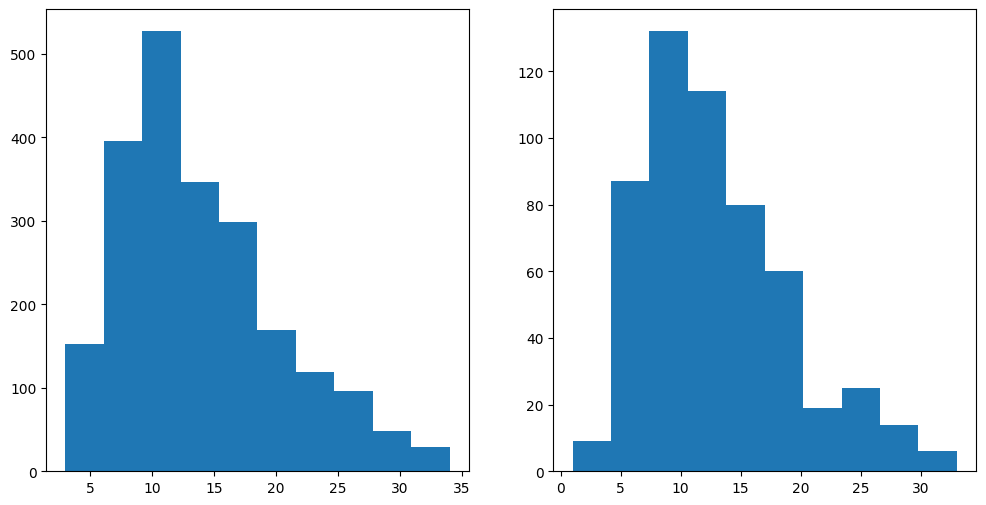

In [246]:
%matplotlib inline

train_lens = [len(s) for s in X_train]
test_lens = [len(s) for s in X_test]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [247]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 100
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
X_train.shape, X_test.shape

((2180, 100), (546, 100))

In [248]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
num_classes=2

In [249]:
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [250]:
#  Modelling

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Activation, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, SimpleRNN

vector_size = 300
model = Sequential()
model.add(Embedding(vocab, vector_size, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(32,8, activation="relu"))
model.add(MaxPooling1D(2))
model.add(Dropout(0.1))
model.add(LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.1))
model.add(Dropout(0.1))
model.add(Dense(8, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(4, activation="relu"))
model.add(Dropout(0.1))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 100, 300)          1611900   
                                                                 
 conv1d_18 (Conv1D)          (None, 93, 32)            76832     
                                                                 
 max_pooling1d_18 (MaxPooli  (None, 46, 32)            0         
 ng1D)                                                           
                                                                 
 dropout_63 (Dropout)        (None, 46, 32)            0         
                                                                 
 lstm_17 (LSTM)              (None, 46, 32)            8320      
                                                                 
 dropout_64 (Dropout)        (None, 46, 32)            0         
                                                     

In [251]:
from random import shuffle
#  tarining
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

epochs = 100
batch_size = 4

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./best_model_cnn1d', monitor='val_accuracy', mode = 'max', verbose=1, save_best_only=True)
history = model.fit(X_train, y_train, batch_size=batch_size, shuffle=True, validation_split=0.1, epochs=epochs, verbose=1, callbacks=[es, mc])

Epoch 1/100
491/491 [==============================] - ETA: 0s - loss: 0.6243 - accuracy: 0.6182
Epoch 1: val_accuracy improved from -inf to 0.80734, saving model to ./best_model_cnn1d
491/491 [==============================] - 53s 93ms/step - loss: 0.6243 - accuracy: 0.6182 - val_loss: 0.4520 - val_accuracy: 0.8073
Epoch 2/100
491/491 [==============================] - ETA: 0s - loss: 0.3383 - accuracy: 0.8736
Epoch 2: val_accuracy improved from 0.80734 to 0.89908, saving model to ./best_model_cnn1d
491/491 [==============================] - 46s 94ms/step - loss: 0.3383 - accuracy: 0.8736 - val_loss: 0.3003 - val_accuracy: 0.8991
Epoch 3/100
491/491 [==============================] - ETA: 0s - loss: 0.1687 - accuracy: 0.9516
Epoch 3: val_accuracy did not improve from 0.89908
491/491 [==============================] - 40s 82ms/step - loss: 0.1687 - accuracy: 0.9516 - val_loss: 0.2657 - val_accuracy: 0.8945
Epoch 4/100
491/491 [==============================] - ETA: 0s - loss: 0.0834 - 

In [252]:
# Evaluation

from keras.models import load_model

saved_model = load_model('./best_model_cnn1d')
train_acc = saved_model.evaluate(X_train, y_train, verbose=1)
test_acc = saved_model.evaluate(X_test, y_test, verbose=1)
print('Train: %.2f%%, Test: %.2f%%' % (train_acc[1]*100, test_acc[1]*100))

18/18 [==============================] - 0s 20ms/step - loss: 0.2218 - accuracy: 0.9286
Train: 98.07%, Test: 92.86%


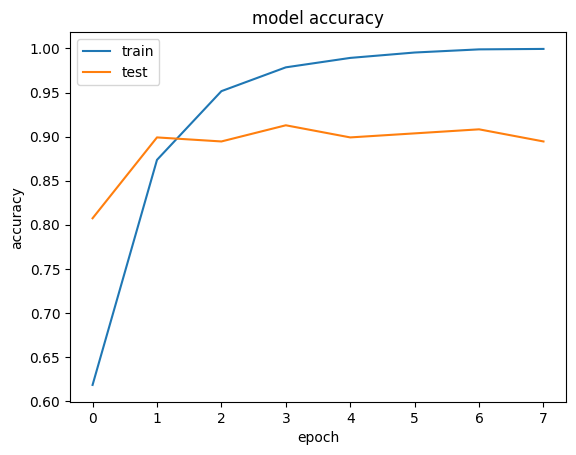

In [253]:
# Identifikasi Overfitting
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

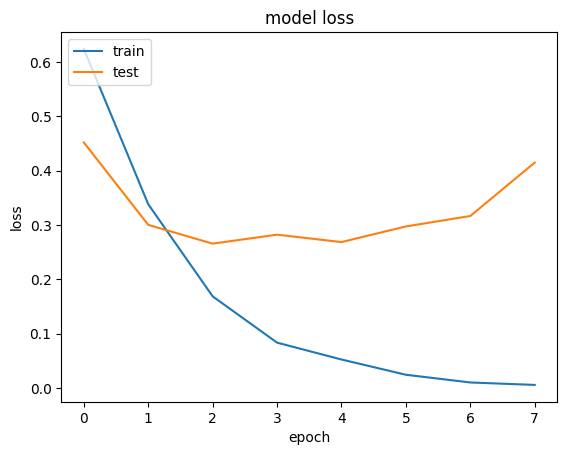

In [254]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [255]:
predicted_sentiments = saved_model.predict(X_test)
sentiments = [1 if score > 0.5 else 0 for score in predicted_sentiments]
positive_percentage = sentiments.count(1) / len(sentiments) * 100
negative_percentage = 100 - positive_percentage

18/18 [==============================] - 1s 19ms/step


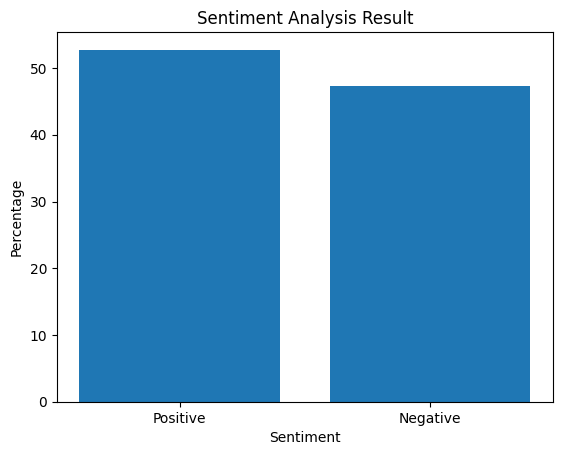

In [256]:
plt.bar(['Positive', 'Negative'], [positive_percentage, negative_percentage])
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.title('Sentiment Analysis Result')
plt.show()

In [257]:
from collections import Counter

# Pisahkan dataset berdasarkan label sentimen
positive_texts = df[df['label'] == 'positive']['id_text']
negative_texts = df[df['label'] == 'negative']['id_text']

# Analisis teks untuk mencari kata-kata yang paling umum
def get_top_words(texts, n=10):
    all_words = " ".join(texts).split()
    word_counts = Counter(all_words)
    top_words = word_counts.most_common(n)
    return top_words

top_positive_words = get_top_words(positive_texts)
top_negative_words = get_top_words(negative_texts)


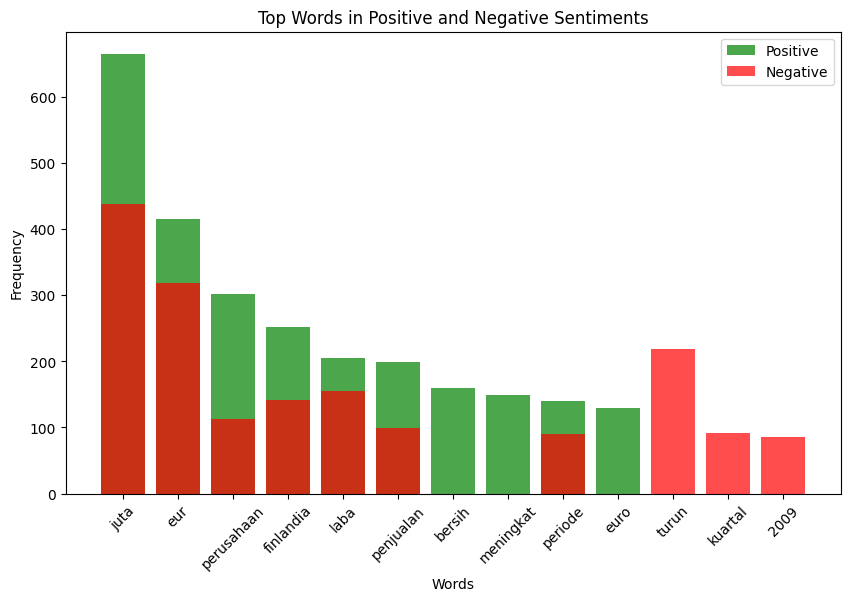

In [258]:
positive_words, positive_word_counts = zip(*top_positive_words)
negative_words, negative_word_counts = zip(*top_negative_words)

# Plot kata-kata yang paling umum
plt.figure(figsize=(10, 6))
plt.bar(positive_words, positive_word_counts, color='green', alpha=0.7, label='Positive')
plt.bar(negative_words, negative_word_counts, color='red', alpha=0.7, label='Negative')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top Words in Positive and Negative Sentiments')
plt.xticks(rotation=45)
plt.legend()
plt.show()

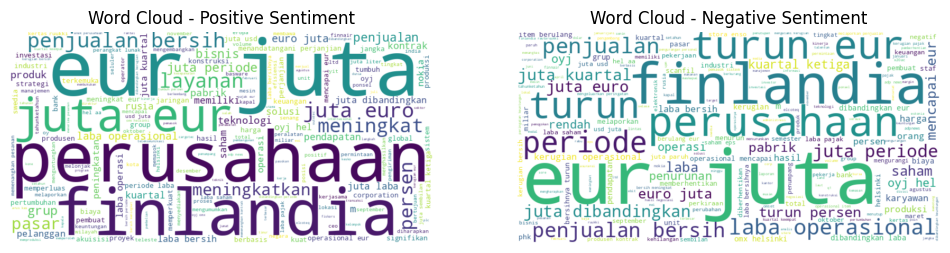

In [259]:
from wordcloud import WordCloud

# Gabungkan kata-kata dalam dataset positif dan negatif
positive_words = " ".join(positive_texts)
negative_words = " ".join(negative_texts)

# Buat Word Cloud untuk kata-kata positif
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_words)

# Buat Word Cloud untuk kata-kata negatif
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_words)

# Plot Word Cloud
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud - Positive Sentiment')
plt.axis('off')

plt.subplot(122)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud - Negative Sentiment')
plt.axis('off')

plt.show()
